In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from impyute.imputation.cs import mice
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from xgboost import plot_importance

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import itertools

In [83]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


# Data Processing and EDA

In [3]:
#read in data
all_fund = pd.read_csv('all_companies_fund.csv') #2000-2019
all_bank = pd.read_csv('all_bankruptcies.csv', encoding = "ISO-8859-1") #2000-2019

C:\Users\Derrick\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (2,33,37,955,956,957,962,972,976,977,982) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Derrick\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (263,341) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#keys to join all databases
key_table = all_fund[['cik', 'GVKEY']] 
key_table = key_table.drop_duplicates()
key_table.head()

,cik,GVKEY
0,1750.0,1004
19,910627.0,1010
23,61478.0,1013
34,2668.0,1019
36,319126.0,1021


In [5]:
mask = all_fund['stalt'] == 'TL'
tl = all_fund[mask]
tl

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
73,1045,P,01,NR,NaN,NaN,01/05/2012,11/30/2013,12/31/2012,2012.0,...,4.0,4512,605.0,600.0,B-,TX,0.0,www.aa.com,NaN,NaN
473,1164,P,01,NR,NaN,NaN,07/30/2002,03/31/2004,12/31/2002,2002.0,...,10.0,4813,463.0,974.0,NaN,NJ,0.0,www.wcom.com/home.shtml,01/09/2006,NaN
867,1263,N,01C,NU,NaN,NaN,12/01/2000,12/31/2001,12/31/2001,2001.0,...,6.0,3312,460.0,970.0,NaN,ON,2.0,www.algoma.com,NaN,NaN
868,1263,P,01,NR,NaN,NaN,12/01/2000,01/31/2002,12/31/2001,2001.0,...,6.0,3312,460.0,970.0,NaN,ON,2.0,www.algoma.com,NaN,NaN
1167,1388,C,00X,NU,NaN,NaN,01/01/1983,E,12/31/2011,2011.0,...,1.0,4512,605.0,600.0,NaN,TX,1.0,www.aa.com,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236932,273726,P,01,LC,93338.0,53385.0,04/15/2010,06/30/2018,12/31/2017,2017.0,...,2.0,1381,NaN,NaN,NaN,NaN,0.0,www.seadrill.com,NaN,04/15/2010
237802,294524,C,00X,NR,NaN,NaN,01/01/2006,04/29/2010,12/31/2009,2009.0,...,1.0,2820,NaN,NaN,B+,NaN,0.0,www.lyondellbasell.com,NaN,NaN
237889,296944,N,01,NR,NaN,NaN,01/29/2014,E,12/31/2017,2017.0,...,2.0,1381,NaN,NaN,NaN,NaN,3.0,www.nadlcorp.com,07/03/2018,NaN
237890,296944,P,02,LC,14417.0,54709.0,01/29/2014,07/03/2018,12/31/2017,2017.0,...,2.0,1381,NaN,NaN,NaN,NaN,3.0,www.nadlcorp.com,07/03/2018,NaN


In [6]:
all_fund[all_fund['GVKEY'] == 273726][['datadate','stalt','cik']]

,datadate,stalt,cik
236923,12/31/2008,NaN,1737706.0
236924,12/31/2009,NaN,1737706.0
236925,12/31/2010,NaN,1737706.0
236926,12/31/2011,NaN,1737706.0
236927,12/31/2012,NaN,1737706.0
236928,12/31/2013,NaN,1737706.0
236929,12/31/2014,NaN,1737706.0
236930,12/31/2015,NaN,1737706.0
236931,12/31/2016,NaN,1737706.0
236932,12/31/2017,TL,1737706.0


In [7]:
all_bank[all_bank['COMPANY_FKEY'] == 1737706]

,BANK_KEY,SUBSID_NAME,BANKRUPTCY_TYPE,LAW_COURT_FKEY,COURT_TYPE_CODE,COURT_NAME,COURT_S_NAME,COURT_LOC_STREET,COURT_LOC_CITY,COURT_LOC_STATE,...,HIWATER_INCMST_REVFY,HIWATER_INCMST_NETINC_QTR_DATE,HIWATER_INCMST_NETINC_QTR,HIWATER_INCMST_NETINC_TTM_DATE,HIWATER_INCMST_NETINC_TTM,HIWATER_INCMST_NETINC_FY_DATE,HIWATER_INCMST_NETINC_FY,NAME_CHANGE_DATE1,NAME_CHANGE_DATE2,NAME_CHANGE_DATE3


## Bankruptcy Data EDA

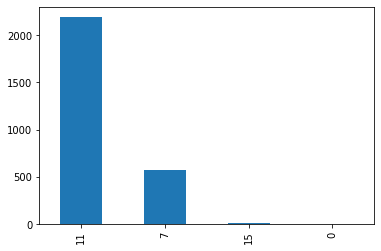

In [8]:
all_bank['BANKRUPTCY_TYPE'].value_counts().plot(kind = 'bar')

In [9]:
#extract useful information
all_bank = all_bank[['BANKRUPTCY_TYPE', 'BANK_BEGIN_DATE', 'SIC_CODE_FKEY', 'SIC_CODE_DESCRIP', 'NAICS_CODE_DESCRIP', 'NAICS_CODE_FKEY', 'SHORT_NAME', 'NAME', 'COMPANY_FKEY']]

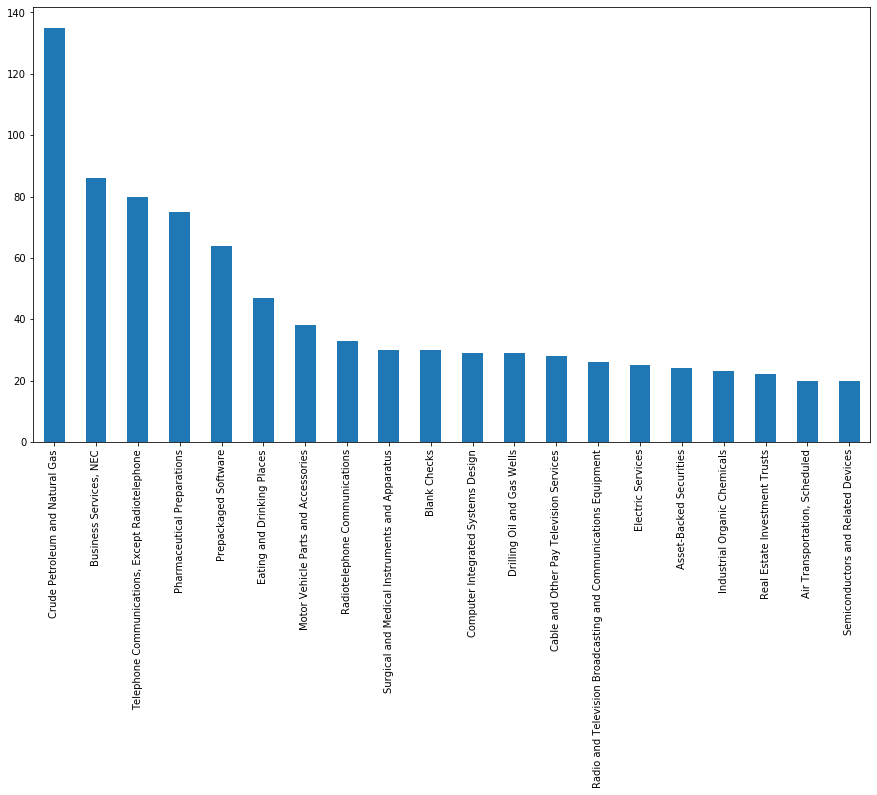

In [10]:
#top 20 industries with most bankruptcies using SIC code

all_bank['SIC_CODE_DESCRIP'].value_counts(ascending = False)[:20].plot(kind = 'bar', figsize = (15,8))

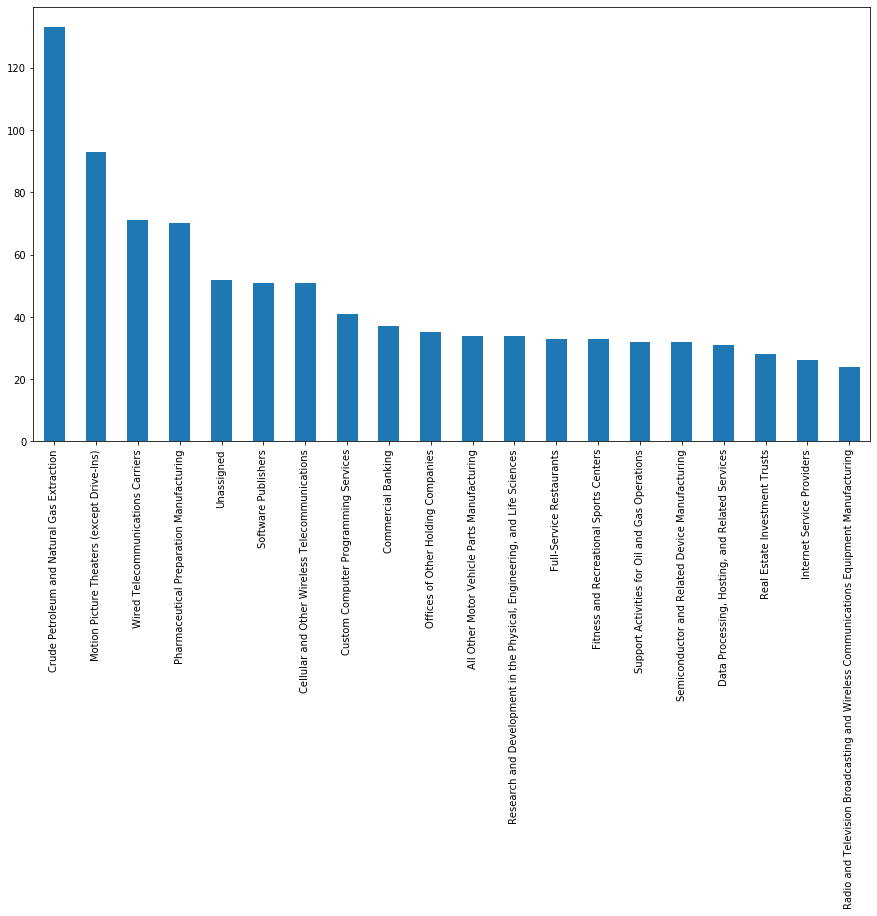

In [11]:
#top 20 industries with most bankruptcies using NICS code

all_bank['NAICS_CODE_DESCRIP'].value_counts(ascending = False)[:20].plot(kind = 'bar', figsize = (15,8))

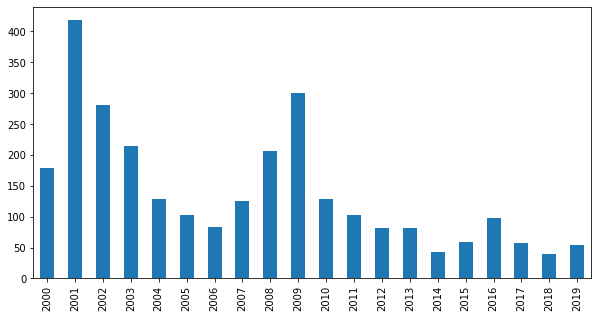

In [12]:
all_bank['year'] = pd.to_datetime(all_bank['BANK_BEGIN_DATE']).dt.year
all_bank['year'].value_counts().sort_index().plot(kind = 'bar', figsize = (10,5))

In [13]:
# gvkey_list = str(list(all_fund['GVKEY'].unique())).strip('\'').strip('[').strip(']').split(', ')

# # Write to txt file to look up relevant companies in Audit Analytics database
# # file = open('all_GVKEY.txt','w')
# # for i in all_fund['GVKEY']:
# #     file.write(str(i))
# #     file.write('\n')
# # file.close()

print(all_fund['GVKEY'].nunique(), 'of unique GVKEYs')
print(all_fund['cik'].nunique(), 'of unique ciks')
print('cik is the only way to join to bankruptcy data, might explain why so many bankruptcies were dropped')

24933 of unique GVKEYs
17998 of unique ciks
cik is the only way to join to bankruptcy data, might explain why so many bankruptcies were dropped


In [14]:
# all_bank.groupby(['year', 'NAICS_CODE_DESCRIP'])[['NAICS_CODE_DESCRIP']].count().unstack().to_csv('industrybank.csv')

In [15]:
# all_bank.groupby(['year', 'SIC_CODE_DESCRIP'])[['NAICS_CODE_DESCRIP']].count().unstack().to_csv('sicbank.csv')

In [16]:
all_bank.shape

(2779, 10)

In [17]:
f_keys = list(all_bank['COMPANY_FKEY'])

In [18]:
ciks = list(key_table['cik'])

In [19]:
#test how many bankrupt Fkeys are in fundamental
x = [] 
for i in f_keys:
    
    if i in ciks:
        continue
    
    else:
        x.append(i)
        print (i, 'not in fundamental')

3662 not in fundamental
3941 not in fundamental
4707 not in fundamental
5588 not in fundamental
6948 not in fundamental
8109 not in fundamental
12105 not in fundamental
13156 not in fundamental
18530 not in fundamental
23778 not in fundamental
23778 not in fundamental
27960 not in fundamental
28761 not in fundamental
30419 not in fundamental
30419 not in fundamental
34879 not in fundamental
40730 not in fundamental
43960 not in fundamental
45791 not in fundamental
46601 not in fundamental
47968 not in fundamental
53453 not in fundamental
56824 not in fundamental
57201 not in fundamental
59401 not in fundamental
60064 not in fundamental
60064 not in fundamental
65202 not in fundamental
67199 not in fundamental
70412 not in fundamental
72655 not in fundamental
75234 not in fundamental
76741 not in fundamental
79839 not in fundamental
82925 not in fundamental
87888 not in fundamental
94026 not in fundamental
94601 not in fundamental
96294 not in fundamental
97579 not in fundamental
99321 

1046777 not in fundamental
1047153 not in fundamental
1047368 not in fundamental
1047860 not in fundamental
1048845 not in fundamental
1049618 not in fundamental
1049620 not in fundamental
1049889 not in fundamental
1050119 not in fundamental
1050835 not in fundamental
1051254 not in fundamental
1051381 not in fundamental
1052245 not in fundamental
1054524 not in fundamental
1054748 not in fundamental
1054992 not in fundamental
1055131 not in fundamental
1055684 not in fundamental
1056286 not in fundamental
1057725 not in fundamental
1057827 not in fundamental
1057831 not in fundamental
1057834 not in fundamental
1057836 not in fundamental
1058627 not in fundamental
1058628 not in fundamental
1058629 not in fundamental
1058631 not in fundamental
1058767 not in fundamental
1058956 not in fundamental
1059363 not in fundamental
1059364 not in fundamental
1059567 not in fundamental
1059570 not in fundamental
1059572 not in fundamental
1059573 not in fundamental
1059576 not in fundamental
1

1238289 not in fundamental
1244041 not in fundamental
1244087 not in fundamental
1252956 not in fundamental
1255107 not in fundamental
1256582 not in fundamental
1257296 not in fundamental
1265238 not in fundamental
1265239 not in fundamental
1265241 not in fundamental
1265242 not in fundamental
1265243 not in fundamental
1265244 not in fundamental
1265245 not in fundamental
1265251 not in fundamental
1265253 not in fundamental
1265254 not in fundamental
1265255 not in fundamental
1265256 not in fundamental
1265259 not in fundamental
1265260 not in fundamental
1265262 not in fundamental
1265263 not in fundamental
1265264 not in fundamental
1265265 not in fundamental
1265266 not in fundamental
1265267 not in fundamental
1265268 not in fundamental
1265269 not in fundamental
1265271 not in fundamental
1265273 not in fundamental
1265274 not in fundamental
1265275 not in fundamental
1265275 not in fundamental
1265276 not in fundamental
1265283 not in fundamental
1265284 not in fundamental
1

1585644 not in fundamental
1588242 not in fundamental


In [20]:
print('Of', len(f_keys), 'bankrupt companies,', len(x), 'companies are not in fundamental dataset')

Of 2779 bankrupt companies, 1085 companies are not in fundamental dataset


In [21]:
# # gvkey_list = str(list(all_fund['GVKEY'].unique())).strip('\'').strip('[').strip(']').split(', ')

# # Write to txt file to look up relevant companies in Audit Analytics database
# file = open('all_fkey.txt','w')
# for i in all_bank['COMPANY_FKEY']:
#     file.write(str(i))
#     file.write('\n')
# file.close()

In [22]:
#used bankruptcy Fkey to query fundamental data, turns out a lot of ciks do not return fundamental data
fund_bank = pd.read_csv('fund_bank.csv')
fund_bank['cik'].nunique()

C:\Users\Derrick\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (23,33,955,956,958,959,965,976,977,980,981,982,983,985,989,995,996,999,1002,1005,1010,1017,1018,1021,1025,1030,1033,1034,1039,1049,1050,1055,1056,1057,1058,1059,1060,1061,1065,1066,1069,1070,1072,1074,1076,1077,1081,1082,1083,1093,1095,1099,1100,1107,1111,1112,1113,1114,1116,1120,1127,1134,1137,1141,1144,1145,1146,1148,1149,1150,1159,1160,1162,1163,1164,1165,1167,1168,1829,1830,1836,1850,1851) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1798

In [23]:
print('will move forward with the companies with fundamental data')
print('might be benefitial to figure out why so many companies do not have fundamental data')

will move forward with the companies with fundamental data
might be benefitial to figure out why so many companies do not have fundamental data


## Merge fundamental and bankruptcy and financial ratios


In [24]:
fund_bank = pd.merge(all_fund, all_bank, left_on = 'cik', right_on = 'COMPANY_FKEY', suffixes = ('_fund', '_bank'), how = 'left')
fund_bank['cik'].nunique()

17998

In [25]:
bankrupt_key  = pd.merge(all_bank, key_table, left_on = 'COMPANY_FKEY', right_on = 'cik', suffixes = ('_ratio', '_key'), how = 'inner')


In [26]:
all_fin_ratios  = pd.read_csv('all_fin_ratios.csv')

In [27]:
all_fin_ratios['gvkey'].nunique()

10728

In [28]:
#only keep year end financial ratios for each company
all_fin_ratios=all_fin_ratios.drop_duplicates(subset=['gvkey','qdate'], keep='last')
all_fin_ratios['qmonth']=pd.to_datetime(all_fin_ratios['qdate']).dt.month
mask= all_fin_ratios['qmonth']==12
all_fin_ratios= all_fin_ratios[mask]

all_fin_ratios.shape

(75263, 76)

In [29]:
fin_gv = list(all_fin_ratios['gvkey'].unique())

fund_gv = list(all_fund['GVKEY'].unique())

# test how many bankrupt Fkeys are in fundamental
x = [] 
for i in fin_gv:
    
    if i in fund_gv:
        continue
    
    else:
        x.append(i)
        print (i, 'not in fundamental')

1411 not in fundamental
1542 not in fundamental
3391 not in fundamental
4806 not in fundamental
5181 not in fundamental
6282 not in fundamental
7503 not in fundamental
7837 not in fundamental
8248 not in fundamental
11768 not in fundamental
13486 not in fundamental
14825 not in fundamental
17164 not in fundamental
17560 not in fundamental
18693 not in fundamental
18769 not in fundamental
18914 not in fundamental
22525 not in fundamental
23692 not in fundamental
24779 not in fundamental
25271 not in fundamental
29402 not in fundamental
29982 not in fundamental
30240 not in fundamental
30599 not in fundamental
30757 not in fundamental
30764 not in fundamental
31097 not in fundamental
61606 not in fundamental
62004 not in fundamental
62069 not in fundamental
62338 not in fundamental
62450 not in fundamental
62513 not in fundamental
63207 not in fundamental
64509 not in fundamental
64996 not in fundamental
65629 not in fundamental
65667 not in fundamental
65882 not in fundamental
65936 not

61326 not in fundamental
61370 not in fundamental
61372 not in fundamental
61413 not in fundamental
61464 not in fundamental
61507 not in fundamental
61508 not in fundamental
61553 not in fundamental
61590 not in fundamental
61601 not in fundamental
61700 not in fundamental
61705 not in fundamental
61780 not in fundamental
61873 not in fundamental
61999 not in fundamental
62137 not in fundamental
62284 not in fundamental
62314 not in fundamental
62320 not in fundamental
62356 not in fundamental
62368 not in fundamental
62377 not in fundamental
62433 not in fundamental
62519 not in fundamental
62535 not in fundamental
62659 not in fundamental
62690 not in fundamental
62697 not in fundamental
62707 not in fundamental
62737 not in fundamental
62759 not in fundamental
62932 not in fundamental
63013 not in fundamental
63140 not in fundamental
63182 not in fundamental
63199 not in fundamental
63200 not in fundamental
63201 not in fundamental
63225 not in fundamental
63278 not in fundamental


In [30]:
print('Of', len(fin_gv), 'companies with financial ratios', len(x), 'companies are not in fundamental dataset')

Of 9466 companies with financial ratios 560 companies are not in fundamental dataset


In [31]:
fin_gv = list(all_fin_ratios['gvkey'].unique())

fund_gv = list(all_fund['GVKEY'].unique())

# test how many bankrupt Fkeys are in fundamental
x = [] 
for i in fund_gv:
    
    if i in fin_gv:
        continue
    
    else:
        x.append(i)
#         print (i, 'not in fundamental')

print('Of', len(fund_gv), 'companies in fundamentals', len(x), 'companies are not in the financial ratio dataset')        

Of 24933 companies in fundamentals 16027 companies are not in the financial ratio dataset


In [32]:
fin_ratio_bankruptcy = pd.merge(all_fin_ratios, bankrupt_key, left_on = 'gvkey', right_on = 'GVKEY', suffixes = ('_finratio', '_bankrupt'), how = 'left')


In [33]:
mask = pd.to_datetime(fin_ratio_bankruptcy['adate']).dt.year + 1 == pd.to_datetime(fin_ratio_bankruptcy['BANK_BEGIN_DATE']).dt.year

fin_ratio_bankruptcy['bankrupted'] = np.where(mask, 1,0)

In [34]:
#might want to check why so few bankruptcies exist in this final merge dataset
fin_ratio_bankruptcy['bankrupted'].sum()

518

In [35]:
fin_ratio_bankruptcy['year'] = pd.to_datetime(fin_ratio_bankruptcy['adate']).dt.year
all_fund['year'] =  pd.to_datetime(all_fund['datadate']).dt.year


In [36]:
fund_ratio_bank  = pd.merge(all_fund, fin_ratio_bankruptcy, left_on = ['GVKEY', 'year'], right_on = ['gvkey', 'year'], suffixes = ('_fund', '_ratio'), how = 'inner')
fund_ratio_bank = fund_ratio_bank.drop(columns = 'GVKEY_ratio')
fund_ratio_bank = fund_ratio_bank.rename(columns = {'GVKEY_fund' : 'GVKEY'})

In [37]:
print('The final dataset includes:',fund_ratio_bank['GVKEY'].nunique(), 'companies, which have fundamental as well as financial ratios values, and', fund_ratio_bank['bankrupted'].sum(), 'bankruptcies')

The final dataset includes: 8673 companies, which have fundamental as well as financial ratios values, and 511 bankruptcies


## Final EDA

In [38]:
#filter for market cap size (in MM)
#recommend using this after creating bankruptcy dummy

def market_cap_size(df, lower, upper):
    
    mask = ((df['mkvalt'] >=lower) & (df['mkvalt'] <=upper))
    df =df[mask]
    
    return df


# #market cap 500M - 1B
# df500 = market_cap_size(fund_ratio_bank, 0,1000)

# df500['GVKEY'].nunique()

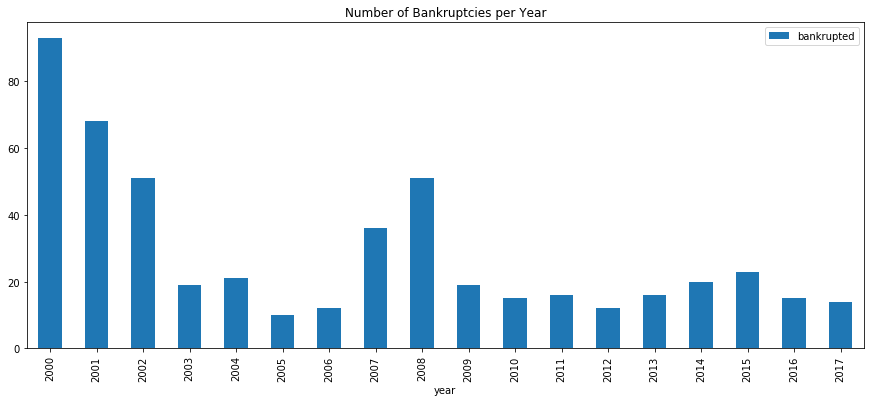

In [39]:
fund_ratio_bank.groupby('year')[['bankrupted']].sum().plot(kind = 'bar', title = 'Number of Bankruptcies per Year', figsize = (15,6))

In [40]:
final_bank = fund_ratio_bank [fund_ratio_bank['bankrupted']==1]

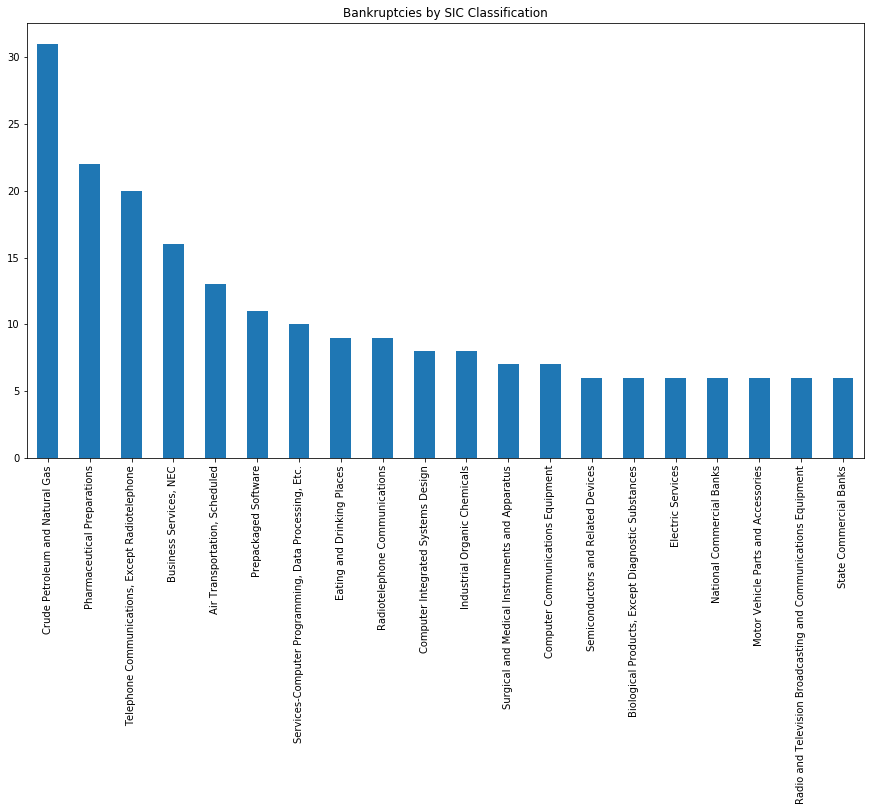

In [41]:
# rotate x labels 45 degrees
final_bank['SIC_CODE_DESCRIP'].value_counts(ascending = False)[:20].plot(kind = 'bar', title = 'Bankruptcies by SIC Classification', figsize = (15,8))

Most bankruptcies occur in small market cap companies


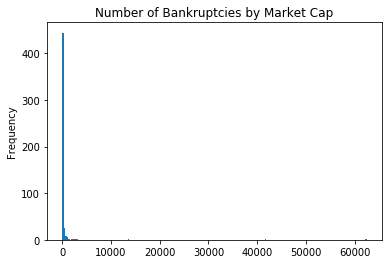

In [42]:
#bankrupt companies usually have small market caps
final_bank['mkvalt'].plot(kind = 'hist', title = 'Number of Bankruptcies by Market Cap', bins = 200)#.value_counts(ascending = False)[:20].plot(kind = 'bar', figsize = (15,8))
print('Most bankruptcies occur in small market cap companies')

## Next steps:
1. figure out why so many bankrupted companies do not have fundamental data (is it how the database was constructed? fundamental dataset would get rid of bankrupted or acquired companies?)

2. figure out why only 500 or so bankruptcies exist in the final dataset, down from 1000 (bankrupt companies with fundamental data) --> hypothesis is some fin ratios companies do not have fundamental data and those happen to be the ones with bankrupt data. Need to check 

3. model development. Note that the current dataset includes data from 2000 - 2019. Need to filter out dates


# Modeling

In [43]:
#CSHO #common shares outstanding
#MKVALT year end market cap

In [44]:
#training periods
mask = (fund_ratio_bank['fyear'] >= 2000) & (fund_ratio_bank['fyear'] <= 2010)
df_2000_2010 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] >= 2000) & (fund_ratio_bank['fyear'] <= 2011)
df_2000_2011 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] >= 2000) & (fund_ratio_bank['fyear'] <= 2012)
df_2000_2012 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] >= 2000) & (fund_ratio_bank['fyear'] <= 2013)
df_2000_2013 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] >= 2000) & (fund_ratio_bank['fyear'] <= 2014)
df_2000_2014 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] >= 2000) & (fund_ratio_bank['fyear'] <= 2015)
df_2000_2015 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] >= 2000) & (fund_ratio_bank['fyear'] <= 2016)
df_2000_2016 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] >= 2000) & (fund_ratio_bank['fyear'] <= 2017)
df_2000_2017 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] >= 2000) & (fund_ratio_bank['fyear'] <= 2018)
df_2000_2018 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] >= 2000) & (fund_ratio_bank['fyear'] <= 2019)
df_2000_2019 = fund_ratio_bank[mask]

In [45]:
#testing periods
mask = (fund_ratio_bank['fyear'] == 2011)
df_2011 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] == 2012)
df_2012 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] == 2013)
df_2013 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] == 2014)
df_2014 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] == 2015)
df_2015 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] == 2016)
df_2016 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] == 2017)
df_2017 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] == 2018)
df_2018 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] == 2019)
df_2019 = fund_ratio_bank[mask]

mask = (fund_ratio_bank['fyear'] == 2020)
df_2020 = fund_ratio_bank[mask]

In [46]:
lista=[]
for i in all_fin_ratios.columns:
    lista.append(i)

In [47]:
lista.append('bankrupted')
lista.append('fyear')

In [48]:
df_2000_2010 = df_2000_2010[lista]

df_2000_2010 = df_2000_2010.drop(columns = ['gvkey'])



In [49]:
df_2011

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,BANK_BEGIN_DATE,SIC_CODE_FKEY,SIC_CODE_DESCRIP,NAICS_CODE_DESCRIP,NAICS_CODE_FKEY,SHORT_NAME,NAME,COMPANY_FKEY,cik_ratio,bankrupted
23,1045,P,01,LC,21020.0,20010.0,01/31/1962,01/04/2012,12/31/2011,2011.0,...,2011-11-29,4512.0,"Air Transportation, Scheduled",Scheduled Passenger Air Transportation,481111.0,AMER AIRLINES,American Airlines Group Inc.,6201.0,6201.0,0
40,1050,P,01,LC,11499.0,176.0,11/28/1980,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
65,1072,C,01,LC,81912.0,30930.0,08/15/1995,E,03/31/2012,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
82,1075,P,01,LU,27991.0,21409.0,01/31/1962,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
111,1076,P,01,LC,10517.0,5674.0,12/01/2010,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72326,277918,P,01,LC,91412.0,51093.0,08/29/2006,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
72328,282553,P,01,LC,82678.0,14266.0,10/18/2010,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
72336,285536,P,01,LC,12581.0,53680.0,02/04/2011,08/31/2012,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
72337,287462,P,01,LC,12615.0,53694.0,03/23/2011,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [158]:
# mask = (df_2000_2010['fyear'] >= 2000) & (df_2000_2010['fyear'] <= 2007)
train = df_2000_2010
test = df_2011

In [51]:
#test=test.reset_index()

In [52]:
#test=test.drop(columns='index')

In [53]:
port_2011= test

In [55]:
port_2011['CAPEI']

0       -0.154
1       83.413
2       15.181
3       21.102
4       20.210
         ...  
3465    -0.896
3466       NaN
3467   -69.029
3468       NaN
3469       NaN
Name: CAPEI, Length: 3470, dtype: float64

In [160]:
y_train= train['bankrupted']
x_train= train.drop(columns=['bankrupted'])
y_test= test[['bankrupted']]
x_test= test.drop(columns=['bankrupted'])

In [161]:
x_test

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,BANKRUPTCY_TYPE,BANK_BEGIN_DATE,SIC_CODE_FKEY,SIC_CODE_DESCRIP,NAICS_CODE_DESCRIP,NAICS_CODE_FKEY,SHORT_NAME,NAME,COMPANY_FKEY,cik_ratio
23,1045,P,01,LC,21020.0,20010.0,01/31/1962,01/04/2012,12/31/2011,2011.0,...,11.0,2011-11-29,4512.0,"Air Transportation, Scheduled",Scheduled Passenger Air Transportation,481111.0,AMER AIRLINES,American Airlines Group Inc.,6201.0,6201.0
40,1050,P,01,LC,11499.0,176.0,11/28/1980,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,1072,C,01,LC,81912.0,30930.0,08/15/1995,E,03/31/2012,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,1075,P,01,LU,27991.0,21409.0,01/31/1962,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
111,1076,P,01,LC,10517.0,5674.0,12/01/2010,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72326,277918,P,01,LC,91412.0,51093.0,08/29/2006,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72328,282553,P,01,LC,82678.0,14266.0,10/18/2010,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72336,285536,P,01,LC,12581.0,53680.0,02/04/2011,08/31/2012,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72337,287462,P,01,LC,12615.0,53694.0,03/23/2011,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
y_test

,bankrupted
23,0
40,0
65,0
82,0
111,0
...,...
72326,0
72328,0
72336,0
72337,0


In [163]:
x_test['CAPEI']

23       -0.154
40       83.413
65       15.181
82       21.102
111      20.210
          ...  
72326    -0.896
72328       NaN
72336   -69.029
72337       NaN
72349       NaN
Name: CAPEI, Length: 3470, dtype: float64

In [164]:
def get_pct(column):
    
    column = float(str(column).rstrip('%')) 
    
    return column

x_train['DIVYIELD'] = x_train['DIVYIELD'].apply(get_pct)
x_test['DIVYIELD'] = x_test['DIVYIELD'].apply(get_pct)

In [165]:
x_train=x_train.drop(columns=['adate','qdate','fyear','public_date','qmonth'])
x_test=x_test.drop(columns=['adate','qdate','fyear','public_date','qmonth'])

In [166]:
x_test=x_test.drop(columns='gvkey')

In [167]:
#only keep na < 10% columns
temp = pd.DataFrame(1 - x_train.isna().sum() / 37103).reset_index()
use_list = temp[temp[0]>0.9]['index'].to_list()

In [168]:
x_train = x_train[use_list]
x_test = x_test[use_list]


In [169]:
x_columns = x_train.columns.tolist()

In [170]:
from sklearn.impute import SimpleImputer
#impute x_test
imp_mean = SimpleImputer( strategy='mean') #for median imputation replace 'mean' with 'median'
imp_mean.fit(x_test)
imputed_test_df = imp_mean.transform(x_test)

x_test = pd.DataFrame(imputed_test_df).set_axis(x_columns, axis=1, inplace=False)

In [171]:
y_test

,bankrupted
23,0
40,0
65,0
82,0
111,0
...,...
72326,0
72328,0
72336,0
72337,0


In [172]:
x_test

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,npm,...,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb
0,-0.15400,0.93819,11.996,-0.159,-0.159,-0.085,-0.085,0.060000,0.248,-0.082000,...,0.982000,29.295000,18.902,1.544413,3.02593,0.000,0.008000,0.294000,0.109,2.754295
1,83.41300,0.53400,6.549,14.138,16.078,16.078,16.078,0.859000,13.679,0.060000,...,1.806000,5.581000,11.410,2.647000,3.23800,0.000,0.001000,0.000000,0.006,2.780000
2,15.18100,1.09200,9.036,16.391,16.391,-18.541,-18.541,1.348000,10.852,-0.072000,...,0.557000,5.858000,10.639,0.705000,0.70500,0.006,0.000000,0.000000,0.111,0.960000
3,21.10200,1.09200,7.464,16.063,16.171,16.171,15.647,1.631000,4.698,0.101000,...,0.254000,7.856000,7.424,0.466000,0.84800,0.000,0.000000,0.000000,0.063,0.920000
4,20.21000,0.62600,2.628,15.350,15.526,19.000,19.000,1.021000,6.725,0.056000,...,1.250000,25.762000,1.700,1.791000,2.07300,0.000,0.032000,0.000000,0.120,1.635000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,-0.89600,0.36900,-1.749,-0.871,-0.871,-0.832,-0.832,1.182000,-1.242,-1.055000,...,0.490000,3.670000,4.952,1.006000,1.25000,0.308,0.000000,0.000000,0.050,2.987000
3466,44.05518,1.03000,-6.131,-2.577,-2.577,-2.577,-2.557,0.393000,-1.654,-0.117000,...,1.896000,9.037000,13.253,2.524000,3.10100,0.120,0.000000,0.000000,-0.201,1.162000
3467,-69.02900,0.23100,7.519,12.269,12.510,10.633,10.633,1.635000,12.897,0.142000,...,0.938000,5.673000,22.166,1.113000,3.54900,0.022,0.004000,0.000000,-0.014,5.803000
3468,44.05518,0.61700,8.447,11.442,11.576,11.714,11.714,1.312000,8.062,0.111000,...,0.851000,8.685000,14.086,1.075000,1.07500,0.011,0.000000,0.013000,0.044,1.284000


# SGD Classifier
imputation: https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779

In [178]:
from sklearn.linear_model import SGDClassifier

# clf = SGDClassifier(loss="log", max_iter=5).fit(x_train, y_train)
# clf.predict_proba(x_test)

In [179]:
x_train

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,npm,...,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb
0,-53.765,0.589,17.205,-16.327,-16.327,-1.674,-1.643,0.778,NaN,-0.467,...,NaN,NaN,NaN,0.990,2.798,0.066,0.000,0.0,NaN,2.190
1,28.326,0.497,12.016,12.852,13.385,15.181,15.181,0.771,20.975,0.062,...,0.650,4.163,8.454,0.666,1.062,0.048,0.000,0.0,-0.016,0.792
2,34.133,0.846,13.648,36.383,36.383,-19.655,-18.387,0.689,5.628,-0.037,...,0.487,3.878,4.786,0.507,1.094,0.089,0.000,0.0,0.078,0.677
3,-293.430,1.698,8.056,19.031,19.031,-9.920,-9.325,0.598,4.541,-0.076,...,0.525,4.987,4.322,0.666,1.228,0.055,0.000,0.0,0.109,0.708
4,-253.970,1.106,12.002,29.365,29.767,57.184,80.481,0.678,5.603,0.015,...,0.561,5.265,5.404,0.678,1.146,0.049,0.000,0.0,0.059,0.761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72323,-2.624,1.376,-0.999,-1.242,-1.242,-1.242,-1.242,2.654,-1.259,-2.001,...,0.319,2.545,9.490,0.418,0.456,0.389,0.000,0.0,-0.034,1.492
72324,-5.804,0.251,-9.957,-4.061,-4.061,-4.061,-4.061,7.485,-12.344,-1.253,...,0.273,4.997,4.701,0.303,0.326,0.218,0.000,0.0,0.176,2.889
72325,-4.169,0.197,-6.888,-5.000,-5.000,-4.583,-4.583,4.040,-8.019,-0.866,...,0.432,3.994,4.836,0.718,0.805,0.214,0.000,0.0,0.156,4.349
72327,NaN,0.438,-14.271,-0.757,-0.757,-0.572,-0.638,0.358,NaN,-0.194,...,NaN,NaN,NaN,2.864,3.136,0.091,0.000,0.0,NaN,1.048


In [180]:
# start the MICE training
# imputed_training=mice(x_train.values)

In [181]:
x_test.columns

Index(['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc',
       'ps', 'pcf', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa',
       'roe', 'roce', 'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'GProf',
       'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio',
       'cash_lt', 'debt_at', 'debt_ebitda', 'lt_debt', 'cash_debt', 'lt_ppent',
       'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'at_turn',
       'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'rd_sale',
       'adv_sale', 'staff_sale', 'accrual', 'ptb'],
      dtype='object')

In [182]:
#knn imputation takes forever
# import sys
# from impyute.imputation.cs import fast_knn
# sys.setrecursionlimit(100000) #Increase the recursion limit of the OS

# # start the KNN training
# imputed_training=fast_knn(x_train.values, k=30)

In [183]:
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer( strategy='mean') #for median imputation replace 'mean' with 'median'
imp_mean.fit(x_train)
imputed_train_df = imp_mean.transform(x_train)

x_train = pd.DataFrame(imputed_train_df).set_axis(x_columns, axis=1, inplace=False)



In [184]:
#SGD
clf = SGDClassifier(loss="log").fit(x_train, y_train)
y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)[:,1]

print ('f1 score:' , f1_score(y_test, y_pred))
print ('roc_auc_score', roc_auc_score(y_test, y_prob))
print('accuracy_score', accuracy_score(y_test, y_pred))

f1 score: 0.0
roc_auc_score 0.4942146369684698
accuracy_score 0.9873198847262248


In [185]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('SGD:', 'TN:', tn, '|FP:' , fp, '|FN:' , fn, '|TP:' ,tp)

SGD: TN: 3426 |FP: 31 |FN: 13 |TP: 0


## XGBOOST

In [77]:
#XGBOOST
xgb = XGBClassifier()
xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)
y_prob = xgb.predict_proba(x_test)[:,1]

print ('f1 score:' , f1_score(y_test, y_pred))
print ('roc_auc_score', roc_auc_score(y_test, y_prob))
print('accuracy_score', accuracy_score(y_test, y_pred))

f1 score: 0.0
roc_auc_score 0.9665450257003627
accuracy_score 0.9959654178674352


In [78]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('XGBOOST:', 'TN:', tn, '|FP:' , fp, '|FN:' , fn, '|TP:' ,tp)

XGBOOST: TN: 3456 |FP: 1 |FN: 13 |TP: 0


In [79]:
confusion_matrix(y_test, y_pred)

array([[3456,    1],
       [  13,    0]], dtype=int64)

In [80]:
pd.DataFrame(xgb.predict_proba(x_test)).sort_values(by =1, ascending =False)

,0,1
1351,0.306770,6.932303e-01
2446,0.505112,4.948877e-01
2676,0.633846,3.661537e-01
1117,0.730767,2.692334e-01
2946,0.745130,2.548698e-01
...,...,...
1959,0.999999,7.117587e-07
1333,0.999999,6.532555e-07
32,0.999999,6.530898e-07
2157,0.999999,6.134738e-07


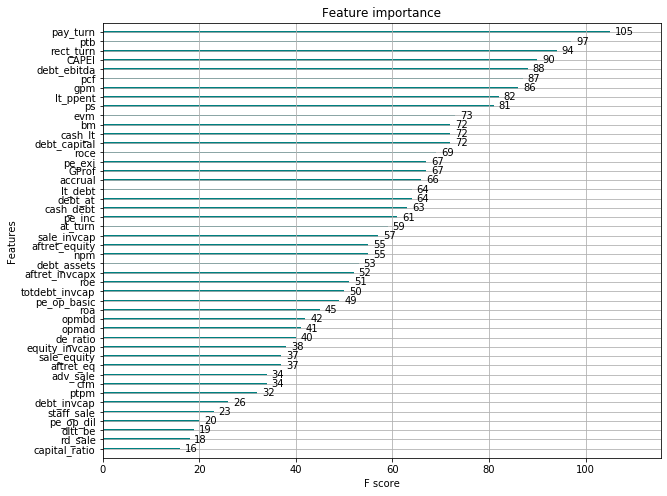

In [81]:
ax =plot_importance(xgb, color = 'teal')
fig = ax.figure
fig.set_size_inches(10,8)

In [96]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [190]:
#grid search 
cv_params = {'max_depth': [1,2], 'min_child_weight': [1,2,3,4]}
fix_params = {'learning_rate': 0.2, 'n_estimators': 100, 'objective': 'binary:logistic', 'max_depth': 5, 'min_child_weight':3}   #other parameters, fixed for the moment 
csv= GridSearchCV(xgb.XGBClassifier(**fix_params), cv_params, scoring = 'f1', cv = 5)

In [191]:
csv.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_delta_step=None,
                                     max_depth=5, min_child_weight=3,
                                     missing=nan, monotone_constraints=Non...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsampl

In [192]:
csv.cv_results_

{'mean_fit_time': array([1.41611862, 1.50406656, 1.58278575, 1.58635316, 2.25293207,
        2.1354363 , 2.01498752, 2.02133884]),
 'std_fit_time': array([0.07153752, 0.05717535, 0.12720709, 0.13033317, 0.05797563,
        0.09413574, 0.03567248, 0.02615809]),
 'mean_score_time': array([0.03138976, 0.0297637 , 0.02392449, 0.02772593, 0.03214412,
        0.0266027 , 0.02960138, 0.03063922]),
 'std_score_time': array([0.00337261, 0.01137388, 0.00492338, 0.00159562, 0.0030869 ,
        0.00652344, 0.00844675, 0.00430596]),
 'param_max_depth': masked_array(data=[1, 1, 1, 1, 2, 2, 2, 2],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_child_weight': masked_array(data=[1, 2, 3, 4, 1, 2, 3, 4],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'min_child_weight': 1},
  {'max_depth': 1, 'min_chil

In [195]:
y_pred = csv.predict(x_test)
y_prob = csv.predict_proba(x_test)[:,1]

print ('f1 score:' , f1_score(y_test, y_pred))
print ('roc_auc_score', roc_auc_score(y_test, y_prob))
print('accuracy_score', accuracy_score(y_test, y_pred))

f1 score: 0.0
roc_auc_score 0.9787387908591264
accuracy_score 0.9962536023054755


C:\Users\Derrick\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [199]:
port_2011

,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyear,...,BANK_BEGIN_DATE,SIC_CODE_FKEY,SIC_CODE_DESCRIP,NAICS_CODE_DESCRIP,NAICS_CODE_FKEY,SHORT_NAME,NAME,COMPANY_FKEY,cik_ratio,bankrupted
0,1045,P,01,LC,21020.0,20010.0,01/31/1962,01/04/2012,12/31/2011,2011.0,...,2011-11-29,4512.0,"Air Transportation, Scheduled",Scheduled Passenger Air Transportation,481111.0,AMER AIRLINES,American Airlines Group Inc.,6201.0,6201.0,0
1,1050,P,01,LC,11499.0,176.0,11/28/1980,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1072,C,01,LC,81912.0,30930.0,08/15/1995,E,03/31/2012,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1075,P,01,LU,27991.0,21409.0,01/31/1962,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1076,P,01,LC,10517.0,5674.0,12/01/2010,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,277918,P,01,LC,91412.0,51093.0,08/29/2006,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3466,282553,P,01,LC,82678.0,14266.0,10/18/2010,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3467,285536,P,01,LC,12581.0,53680.0,02/04/2011,08/31/2012,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3468,287462,P,01,LC,12615.0,53694.0,03/23/2011,E,12/31/2011,2011.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [200]:
x_test

,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,npm,...,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,staff_sale,accrual,ptb
0,-0.15400,0.93819,11.996,-0.159,-0.159,-0.085,-0.085,0.060000,0.248,-0.082000,...,0.982000,29.295000,18.902,1.544413,3.02593,0.000,0.008000,0.294000,0.109,2.754295
1,83.41300,0.53400,6.549,14.138,16.078,16.078,16.078,0.859000,13.679,0.060000,...,1.806000,5.581000,11.410,2.647000,3.23800,0.000,0.001000,0.000000,0.006,2.780000
2,15.18100,1.09200,9.036,16.391,16.391,-18.541,-18.541,1.348000,10.852,-0.072000,...,0.557000,5.858000,10.639,0.705000,0.70500,0.006,0.000000,0.000000,0.111,0.960000
3,21.10200,1.09200,7.464,16.063,16.171,16.171,15.647,1.631000,4.698,0.101000,...,0.254000,7.856000,7.424,0.466000,0.84800,0.000,0.000000,0.000000,0.063,0.920000
4,20.21000,0.62600,2.628,15.350,15.526,19.000,19.000,1.021000,6.725,0.056000,...,1.250000,25.762000,1.700,1.791000,2.07300,0.000,0.032000,0.000000,0.120,1.635000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,-0.89600,0.36900,-1.749,-0.871,-0.871,-0.832,-0.832,1.182000,-1.242,-1.055000,...,0.490000,3.670000,4.952,1.006000,1.25000,0.308,0.000000,0.000000,0.050,2.987000
3466,44.05518,1.03000,-6.131,-2.577,-2.577,-2.577,-2.557,0.393000,-1.654,-0.117000,...,1.896000,9.037000,13.253,2.524000,3.10100,0.120,0.000000,0.000000,-0.201,1.162000
3467,-69.02900,0.23100,7.519,12.269,12.510,10.633,10.633,1.635000,12.897,0.142000,...,0.938000,5.673000,22.166,1.113000,3.54900,0.022,0.004000,0.000000,-0.014,5.803000
3468,44.05518,0.61700,8.447,11.442,11.576,11.714,11.714,1.312000,8.062,0.111000,...,0.851000,8.685000,14.086,1.075000,1.07500,0.011,0.000000,0.013000,0.044,1.284000


In [203]:
bankrupt_proba = pd.DataFrame(csv.predict_proba(x_test))

In [204]:
bankrupt_proba

,0,1
0,0.806733,0.193267
1,0.999668,0.000332
2,0.999453,0.000547
3,0.999783,0.000217
4,0.998642,0.001358
...,...,...
3465,0.973982,0.026018
3466,0.997957,0.002043
3467,0.999476,0.000524
3468,0.999883,0.000117


In [205]:
port2011= pd.merge(bankrupt_proba,port_2011 , left_index=True, right_index=True)

In [115]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print('XGBOOST:', 'TN:', tn, '|FP:' , fp, '|FN:' , fn, '|TP:' ,tp)

XGBOOST: TN: 3457 |FP: 0 |FN: 13 |TP: 0


In [206]:
port2011.to_csv('port.csv')

,0,1,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,...,BANK_BEGIN_DATE,SIC_CODE_FKEY,SIC_CODE_DESCRIP,NAICS_CODE_DESCRIP,NAICS_CODE_FKEY,SHORT_NAME,NAME,COMPANY_FKEY,cik_ratio,bankrupted
0,0.806733,0.193267,1045,P,01,LC,21020.0,20010.0,01/31/1962,01/04/2012,...,2011-11-29,4512.0,"Air Transportation, Scheduled",Scheduled Passenger Air Transportation,481111.0,AMER AIRLINES,American Airlines Group Inc.,6201.0,6201.0,0
1,0.999668,0.000332,1050,P,01,LC,11499.0,176.0,11/28/1980,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0.999453,0.000547,1072,C,01,LC,81912.0,30930.0,08/15/1995,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.999783,0.000217,1075,P,01,LU,27991.0,21409.0,01/31/1962,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0.998642,0.001358,1076,P,01,LC,10517.0,5674.0,12/01/2010,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3465,0.973982,0.026018,277918,P,01,LC,91412.0,51093.0,08/29/2006,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3466,0.997957,0.002043,282553,P,01,LC,82678.0,14266.0,10/18/2010,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3467,0.999476,0.000524,285536,P,01,LC,12581.0,53680.0,02/04/2011,08/31/2012,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3468,0.999883,0.000117,287462,P,01,LC,12615.0,53694.0,03/23/2011,E,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [66]:
#test on 2011 data

In [67]:
x_2011 = df_2011.drop(columns=['adate','qdate','fyear','public_date','qmonth'])[use_list]
y_2011 = df_2011['bankrupted']

imp_mean = SimpleImputer( strategy='mean') #for median imputation replace 'mean' with 'median'
imp_mean.fit(x_2011)
imputed_2011_df = imp_mean.transform(x_2011)

x_2011 = pd.DataFrame(imputed_2011_df).set_axis(x_columns, axis=1, inplace=False)

y_pred = xgb.predict(x_2011)
y_prob = xgb.predict_proba(x_2011)[:,1]

print ('f1 score:' , f1_score(y_2011, y_pred))
print ('roc_auc_score', roc_auc_score(y_2011, y_prob))
print('accuracy_score', accuracy_score(y_2011, y_pred))

f1 score: 0.0
roc_auc_score 0.9752008188513829
accuracy_score 0.9962536023054755


C:\Users\Joseph\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [68]:
y_df = pd.DataFrame(y_2011.array)
pred_df = pd.DataFrame(y_pred)
prob_df = pd.DataFrame(y_prob)

compare_df = pd.concat([y_df, pred_df, prob_df], axis=1).set_axis(['True','Pred', 'Proba'], axis=1, inplace=False)

In [69]:
tn, fp, fn, tp = confusion_matrix(y_2011, y_pred).ravel()
print('XGB on 2011:', 'TN:', tn, '|FP:' , fp, '|FN:' , fn, '|TP:' ,tp)

XGB on 2011: TN: 3457 |FP: 0 |FN: 13 |TP: 0


In [70]:
#test on 2012 data

In [71]:
x_2012 = df_2012.drop(columns=['adate','qdate','fyear','public_date','qmonth'])[use_list]
y_2012 = df_2012['bankrupted']

imp_mean = SimpleImputer( strategy='mean') #for median imputation replace 'mean' with 'median'
imp_mean.fit(x_2012)
imputed_2012_df = imp_mean.transform(x_2012)

x_2012 = pd.DataFrame(imputed_2012_df).set_axis(x_columns, axis=1, inplace=False)

y_pred = xgb.predict(x_2012)
y_prob = xgb.predict_proba(x_2012)[:,1]

print ('f1 score:' , f1_score(y_2012, y_pred))
print ('roc_auc_score', roc_auc_score(y_2012, y_prob))
print('accuracy_score', accuracy_score(y_2012, y_pred))

f1 score: 0.15384615384615385
roc_auc_score 0.9603372215756854
accuracy_score 0.9967359050445104


In [72]:
tn, fp, fn, tp = confusion_matrix(y_2012, y_pred).ravel()
print('XGB on 2011:', 'TN:', tn, '|FP:' , fp, '|FN:' , fn, '|TP:' ,tp)

XGB on 2011: TN: 3358 |FP: 1 |FN: 10 |TP: 1


In [73]:
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

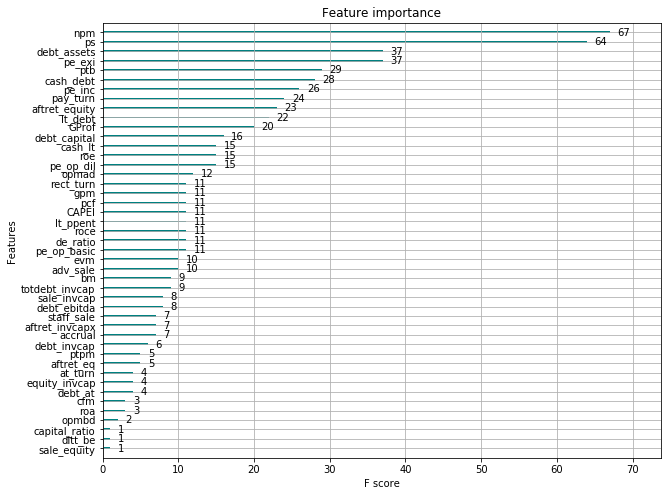

In [74]:
ax =plot_importance(xgb, color = 'teal')
fig = ax.figure
fig.set_size_inches(10,8)

npm: Net Profit Margin	
ps: Price/Sales	
debt_assets: Total Debt/Total Assets	
PE_exi: 	P/E (Diluted, Excl. EI)
ptb: Price/Book	
cash_debt: Cash Flow/Total Debt	
pe_inc: P/E (Diluted, Incl. EI)	
pay_turn: Payables Turnover	
aftret_equity: After-tax Return on Total Stockholders Equity	
lt_debt: Long-term Debt/Total Liabilities	
Gprof: Gross Profit/Total Assets	
debt_capital: Total Debt/Capital	
cash_lt: Cash Balance/Total Liabilities	


In [82]:
pd.DataFrame(xgb.predict_proba(x_2012)).sort_values(by = 1, ascending = False)

,0,1
2021,0.438288,0.561712
2401,0.455657,0.544343
1430,0.519758,0.480242
2041,0.689029,0.310971
2553,0.705078,0.294922
...,...,...
1941,0.999840,0.000160
2070,0.999840,0.000160
1893,0.999841,0.000159
2817,0.999841,0.000159


In [85]:
x_test.iloc[2406]

CAPEI              16.757
bm                  1.530
evm                12.865
pe_op_basic      -190.000
pe_op_dil        -190.000
pe_exi            -62.000
pe_inc            -87.833
ps                  0.121
pcf                13.245
npm                -0.002
opmbd               0.022
opmad               0.004
gpm                 0.055
ptpm               -0.007
cfm                 0.015
roa                 0.057
roe                -0.012
roce                0.014
aftret_eq          -0.013
aftret_invcapx      0.021
aftret_equity      -0.013
GProf               0.140
equity_invcap       0.631
debt_invcap         0.369
totdebt_invcap      0.390
capital_ratio       0.369
cash_lt             0.023
debt_at             0.282
debt_ebitda         5.001
lt_debt             0.491
cash_debt           0.049
lt_ppent            1.621
dltt_be             0.549
debt_assets         0.543
debt_capital        0.459
de_ratio            1.190
at_turn             2.541
rect_turn          22.885
pay_turn    